<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/06_meerkat_hyb_fu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Classify" hyb/fu calls

## Prerequisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import sys
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime

PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

### Load dataset

On 03.08.2020, generated hyb/fu dataset:

In [ ]:
df_fu_only = pd.read_pickle(DATA+'interactive_plot_df_fu_only') 

In [ ]:
df_fu_only.head(4)

,Name,call_lable,indv,raw_audio,stretched_spectrograms,denoised_stretched_spectrograms,duration_s,certain_yn,UMAP1,UMAP2,UMAP3
27244,HYB [LEAD + CC],fu/hyb,HRT,"[0.0234375, 0.01953125, 0.0234375, 0.017578125...","[[-17.500807, -14.801298, -13.165972, -14.3510...","[[36.025368, 32.888, 29.391817, 24.40986, 21.8...",0.198,y,3.232423,1.133456,5.226632
27245,HYB [CC + LEAD],fu/hyb,HRT,"[0.005859375, 0.0078125, 0.013671875, 0.003906...","[[-12.528769, -13.270456, -14.6460285, -13.184...","[[40.552284, 30.489008, 26.989344, 23.931791, ...",0.159,y,3.949984,0.699307,5.525731
27246,HYB [CC + LEAD],fu/hyb,HRT,"[0.048828125, 0.029296875, 0.015625, 0.0097656...","[[-17.513077, -14.152397, -13.090355, -15.3907...","[[44.029728, 39.67316, 34.686623, 30.64796, 32...",0.150,y,4.047125,0.719069,5.459079
27247,HYB [CC + AGG],fu/hyb,HRT,"[0.048828125, 0.05859375, 0.044921875, 0.02148...","[[-35.253723, -37.56826, -22.705854, -21.93972...","[[25.261524, 16.750294, 26.19335, 25.529036, 1...",0.356,y,3.690878,0.065397,9.181638


--> missing information about focal/nonfocal, and denoised_spectrograms (unstretched). Re-do spectrograms based on raw audio, also re-extract focal vs. nonfocal information.

### Remove nonfocal

In [ ]:
lablenames = df_fu_only.Name.values
nf_list = ['nf', 'NF', 'NONFOC', 'nonfoc']

nonfocal_yn = ['y' if any(substring in y for substring in nf_list)==True else 'n' for y in lablenames]

In [ ]:
pd.Series(nonfocal_yn).value_counts()

n    1032
y      92
dtype: int64

In [ ]:
df_fu_only['nonfocal_yn'] = nonfocal_yn

In [ ]:
df = df_fu_only.loc[df_fu_only['nonfocal_yn']=='n',:]
df.shape

(1032, 12)

In [ ]:
df.head(3)

,Name,call_lable,indv,raw_audio,stretched_spectrograms,denoised_stretched_spectrograms,duration_s,certain_yn,UMAP1,UMAP2,UMAP3,nonfocal_yn
27244,HYB [LEAD + CC],fu/hyb,HRT,"[0.0234375, 0.01953125, 0.0234375, 0.017578125...","[[-17.500807, -14.801298, -13.165972, -14.3510...","[[36.025368, 32.888, 29.391817, 24.40986, 21.8...",0.198,y,3.232423,1.133456,5.226632,n
27245,HYB [CC + LEAD],fu/hyb,HRT,"[0.005859375, 0.0078125, 0.013671875, 0.003906...","[[-12.528769, -13.270456, -14.6460285, -13.184...","[[40.552284, 30.489008, 26.989344, 23.931791, ...",0.159,y,3.949984,0.699307,5.525731,n
27246,HYB [CC + LEAD],fu/hyb,HRT,"[0.048828125, 0.029296875, 0.015625, 0.0097656...","[[-17.513077, -14.152397, -13.090355, -15.3907...","[[44.029728, 39.67316, 34.686623, 30.64796, 32...",0.150,y,4.047125,0.719069,5.459079,n


### Infer samplerate

Shit, samplerate is missing! Again, dirty infer.

In [ ]:
frames = [len(x) for x in df['raw_audio']]
df['samplerate_hz'] = frames/df['duration_s']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Everything close to 8000 will go to 8000, everything close to 48000 to 48000

def adjust_samplerate(sr):
  diff_to_8000 = abs(8000-sr)
  diff_to_48000 = abs(48000-sr)

  if diff_to_8000<200:
    y = 8000
  elif diff_to_48000<200:
    y = 48000
  else:
    y=sr

  return y

In [ ]:
true_sr = [adjust_samplerate(sr) for sr in df['samplerate_hz']]
pd.Series(true_sr).value_counts()

8000     952
48000     80
dtype: int64

In [ ]:
df['samplerate_hz'] = true_sr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Re-do spectrograms etc.

In [ ]:
# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients
FMAX = 4000


# Function that generates mel spectrogram from audio data
# Input: data: Audio data (np array of floats), 
#        rate: samplerate in Hz (integer)
#        n_mels: number of mel bands (integer)
#        window: spectrogram window generation type (String)
#        fft_win: window length in s (float)
#        fft_hop: hop between window start in s (float)
# Output: Spectrogram (np array of floats)

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = FMAX, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro

def generate_stretched_mel_spectrogram(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max)
    
    s = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                       sr=sr,
                                       n_mels=n_mels,
                                       fmax=FMAX)
        
    #spectro = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform

    return s

In [ ]:
df = df.drop(columns=['stretched_spectrograms', 'denoised_stretched_spectrograms', 'UMAP1', 'UMAP2', 'UMAP3'])

In [ ]:
spectrograms = df.apply(lambda row: generate_mel_spectrogram(row['raw_audio'], 
                                                             row['samplerate_hz'], 
                                                             N_MELS, 
                                                             WINDOW, 
                                                             FFT_WIN , 
                                                             FFT_HOP), 
                        axis=1)

df['spectrograms'] = spectrograms

In [ ]:
denoised = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['spectrograms']]
df['denoised_spectrograms'] = denoised

In [ ]:
MAX_DURATION = 0.5

# Generate stretched spectrograms
spectrograms = df.apply(lambda row: generate_stretched_mel_spectrogram(row['raw_audio'],
                                                                       row['samplerate_hz'],
                                                                       row['duration_s'],
                                                                       N_MELS,
                                                                       WINDOW,
                                                                       FFT_WIN,
                                                                       FFT_HOP),
                        axis=1)

df['stretched_spectrograms'] = spectrograms

denoised_stretched = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['stretched_spectrograms']]
df['denoised_stretched_spectrograms'] = denoised_stretched

In [ ]:
df.to_pickle(DATA+'focal_hybfu_df')

### Merge datasets

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n'] # for focal
df.reset_index(inplace=True)

df_hyb_fu = pd.read_pickle(DATA+'focal_hybfu_df')
df_hyb_fu['index_id'] = df_hyb_fu.index

In [ ]:
df_hyb_fu['index_id'] = df_hyb_fu.index
df_hyb_fu.reset_index(inplace=True)

In [ ]:
df_hyb_fu['hyb_fu_yn'] = ['y']*df_hyb_fu.shape[0]
df['hyb_fu_yn'] = ['n']*df.shape[0]

In [ ]:
df = df[df_hyb_fu.columns]

In [ ]:
df.head(4)

,index,Name,call_lable,indv,raw_audio,duration_s,certain_yn,nonfocal_yn,samplerate_hz,spectrograms,denoised_spectrograms,stretched_spectrograms,denoised_stretched_spectrograms,index_id,hyb_fu_yn
0,1598,ALARM,al,HMB,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...",0.178,y,n,8000,"[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...",1598,n
1,1599,ALARM,al,HMB,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...",0.317,y,n,8000,"[[-21.059677, -20.16883, -20.029144, -18.70754...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...",1599,n
2,1600,ALARM,al,HMB,"[0.005859375, 0.005859375, 0.0078125, 0.005859...",0.192,y,n,8000,"[[-13.698711, -14.600319, -16.215317, -15.7289...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[-18.871624, -18.160267, -16.079659, -15.3467...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...",1600,n
3,1601,ALARM,al,HMB,"[0.001953125, 0.00390625, 0.00390625, 0.003906...",0.134,y,n,8000,"[[-15.611752, -15.137981, -14.848536, -16.0097...","[[20.75996, 18.54282, 15.484863, 12.944105, 11...","[[-16.879604, -17.779907, -17.648483, -17.0208...","[[32.35832, 27.98457, 24.143658, 22.213814, 23...",1601,n


In [ ]:
all = df.append(df_hyb_fu, ignore_index=True)

In [ ]:
all.hyb_fu_yn.value_counts()

n    6687
y    1032
Name: hyb_fu_yn, dtype: int64

In [ ]:
all.to_pickle(DATA+'df_focal_hyb_fu')

# Analysis

In [ ]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

## Load dataset

In [ ]:
df = pd.read_pickle(DATA+'df_focal_hyb_fu')

## UMAP with all

In [ ]:
specs = df.denoised_spectrograms.values 

In [ ]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

In [ ]:
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0)

In [ ]:
embedding = reducer.fit_transform(data)
embedding.shape 

(7719, 5)

In [ ]:
x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
scat_labels = df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('fu/hyb') # make these custom

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

color_dict['fu/hyb'] = (1,0,0) # make them red

c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = df.indv.values+" "+df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

## UMAP project_transform

In [ ]:
df['call_lable'].value_counts()

sn        1881
cc        1479
soc       1224
fu/hyb    1032
mo         836
al         677
agg        399
ld         191
Name: call_lable, dtype: int64

In [ ]:
df_clear = df.loc[df['call_lable']!='fu/hyb',:]
df_hybfu = df.loc[df['call_lable']=='fu/hyb',:]

In [ ]:
specs = df_clear.denoised_spectrograms.values 
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

In [ ]:
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
umap_res = reducer.fit(data)

In [ ]:
# Project hyb/fu datapoints into UMAP space:

specs = df_hybfu.denoised_spectrograms.values 
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
hybfu_data = specs_arr

hybfu_embeddings = np.zeros((hybfu_data.shape[0],5))

for i in range(hybfu_data.shape[0]):
  print('\rProcessing row ',i, end='')
  hybfu_embeddings[i,:] = umap_res.transform(hybfu_data[i:i+1,])

Processing row  1031

In [ ]:
np.save(DATA+'hybfu_embeddings.npy', hybfu_embeddings)

## Visualize

In [ ]:
embedding_non_ambi = umap_res.embedding_
embedding_ambi = hybfu_embeddings

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

In [ ]:
embedding_all = np.concatenate((embedding_non_ambi, embedding_ambi), axis=0)
labels_all = list(df_clear.call_lable.values)+list(df_hybfu.call_lable.values)

x, y, z = embedding_all[:,0], embedding_all[:,1], embedding_all[:,2] 
scat_labels = labels_all
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('fu/hyb') # make these custom

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

color_dict['fu/hyb'] = (1,0,0) # make them red

c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = df.indv.values+" "+df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

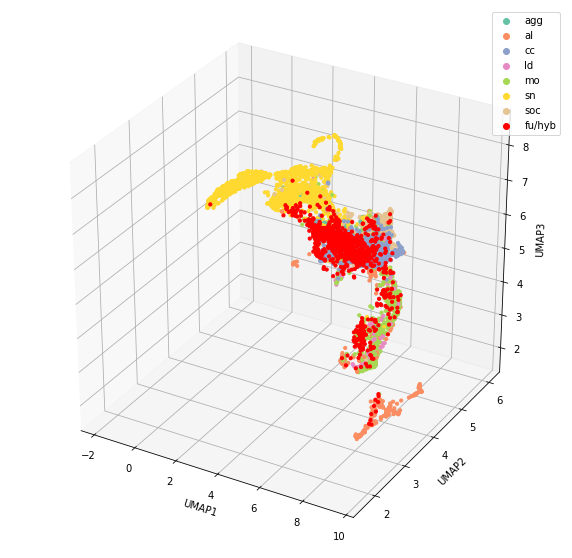

In [ ]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = labels_all
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('fu/hyb') # make these custom

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

color_dict['fu/hyb'] = (1,0,0) # make them red

c = [color_dict[val] for val in scat_labels]


Axes3D.scatter(ax,
               xs = embedding_all[:,0],
               ys = embedding_all[:,1],
               zs = embedding_all[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

labeltypes = labeltypes+['fu/hyb']
scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

#plt.show()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_hybfu')

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_hybfu.gif', dpi=80, writer='pillow', fps=12)

## "Classify" fu/hyb based on k nearest neighbor

In [ ]:
from scipy.spatial.distance import euclidean as euclid

In [ ]:
# Only unambiguous calls

In [ ]:
k=5

In [ ]:
# FOR UMAP WITH ALL

embedding_non_ambi = embedding[df['hyb_fu_yn']=='n',:]
embedding_ambi = embedding[df['hyb_fu_yn']=='y',:]

non_ambi_labels = df.loc[df['hyb_fu_yn']=='n',:].call_lable.values
ambi_labelnames = df.loc[df['hyb_fu_yn']=='y',:].Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

In [ ]:
# OR IF USED PROJECT_TRANSFORM:

embedding_non_ambi = umap_res.embedding_
embedding_ambi = hybfu_embeddings

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

In [ ]:
neighbors = []
for i in range(embedding_ambi.shape[0]):
  print('\rProcessing row ',i, end='')
  x = embedding_ambi[i,:]
  distances = np.asarray([euclid(x,y) for y in embedded_list])
  neighbor_inds = np.argsort(distances)[:k]
  neighbor_labels = [non_ambi_labels[ind] for ind in neighbor_inds]
  neighbors.append(neighbor_labels)

Processing row  1031

In [ ]:
i=0
print(ambi_labelnames[i], neighbors[i])

HYB [LEAD + CC] ['cc', 'cc', 'cc', 'cc', 'cc']


To what percentage can the hyb/fu calls be assigned to either/or of the indicated labels by majority vote?

### Make list of hybfu labels

This is a PAIN to automate, because different wordings are used, sometimes there is a space between '+', sometimes not... But ok. There seems to be a systematic such that:

HYB [call1+call2]

fu call1+call2

* Remove all *,?,!, etc.
* Find out whether first word is hyb or fu
* Split everything before first space and everything after
* remove brackets in HYB
* remove all empty spaces
* split words based on +
* categorize labels according to the groups

In [ ]:
import re

In [ ]:
labelsep = re.compile('[\?\*\!\%\.\$]') # Match ? * ! %
clean_ambi_lables = [labelsep.sub('', i) for i in ambi_labelnames]

In [ ]:
firstword = [i.split(' ')[0] for i in clean_ambi_lables]

In [ ]:
pd.Series(firstword).value_counts()

fu     770
HYB    262
dtype: int64

In [ ]:
clean_ambi_lables = [i.split(' ', 1)[1] for i in clean_ambi_lables]

In [ ]:
labelsep = re.compile('[()[\]{}]') # Match brackets
clean_ambi_lables = [labelsep.sub('', i) for i in clean_ambi_lables]

In [ ]:
faulty = [x if '+' not in x else x for x in clean_ambi_lables]
pd.Series(faulty).value_counts()

cc+agg             158
SN+CC              144
cc+agg              72
mov+s               61
s+mo                55
                  ... 
s+agg                1
cc+agg 1 or agg      1
ld+s                 1
LD + CC              1
cc+ld                1
Length: 102, dtype: int64

In [ ]:
clean_ambi_lables = [x+'+'+x if '+' not in x else x for x in clean_ambi_lables]

In [ ]:
first_label = [i.split('+', 1)[0] for i in clean_ambi_lables]
second_label = [i.split('+', 1)[1] for i in clean_ambi_lables]

In [ ]:
# Remove all non-alphabaetical
regex = re.compile('[^a-zA-Z]')

first_label = [regex.sub('', i) for i in first_label]
second_label = [regex.sub('', i) for i in second_label]

In [ ]:
pd.Series(first_label).value_counts()

cc       336
SN       178
s        147
mov      138
mo        70
soc       65
CC        55
MOV       17
ld         7
LD         3
agg        3
al         3
MOVE       3
SOC        2
MO         2
LEAD       1
alarm      1
AGG        1
dtype: int64

In [ ]:
call_types = {
    'cc' :["cc","Marker", "Marque", "CC", "MARKER", "MARQUE"],
    'sn' :["sn","subm", "short","^s$", "s", "SN", "SUBM", "SHORT", "S"], 
    'mo' :["mo", "mov", "move", "MO","MOV","MOVE"],
    'agg':["ag", "agg", "aggress", "chat", "growl","AG","AGG","AGGRESS","CHAT","GROWL"],
    'ld' :["ld","LD","lead","LEAD"],
    'soc':["soc","SOCIAL", "so", "SOC", "social"],
    'al' :["al", "AL","ALARM", "alarm"]#,
    #'fu/hyb': ["fu", "FU", "Fu", 'HYB', 'hyb', 'Hyb']
    }
    
# make dictionary labels to calls
labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])

In [ ]:
check = [lable if lable not in labels_to_calls.keys() else "recognized" for lable in first_label]
pd.Series(check).value_counts()

recognized    1032
dtype: int64

In [ ]:
pd.Series(second_label).value_counts()

agg         276
CC          153
ld          134
s           117
soc          96
mo           69
cc           46
LD           38
AGG          25
mov          18
MOVE         13
al            9
SOC           8
MO            7
UNK           5
LEAD          4
MOV           4
SN            3
ALARM         2
md            1
c             1
alarm         1
aggoragg      1
cdeedrr       1
dtype: int64

In [ ]:
check = [lable if lable not in labels_to_calls.keys() else "recognized" for lable in second_label]
pd.Series(check).value_counts()

recognized    1023
UNK              5
c                1
cdeedrr          1
aggoragg         1
md               1
dtype: int64

In [ ]:
first_label = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in first_label]
second_label = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in second_label]

In [ ]:
pd.Series(second_label).value_counts()

agg        301
cc         199
ld         176
sn         120
mo         111
soc        104
al          12
unknown      9
dtype: int64

In [ ]:
hybfu_calls = list(zip(firstword, first_label, second_label))

### Save dataframe

What percentage

In [ ]:
hybfu_classi = pd.DataFrame(list(zip(ambi_labelnames, firstword, first_label, second_label)), columns =['Name', 'hybfu_type', 'first_label', 'second_label']) 

In [ ]:
for i in range(k):
  hybfu_classi['neighbor_'+str(i+1)] = [neighbor[i] for neighbor in neighbors]

In [ ]:
#hybfu_classi['index_id'] = df_hyb_fu['index_id']
hybfu_classi['index_id'] = df_hybfu['index_id']

In [ ]:
hybfu_classi.head(30)

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,index_id
0,HYB [LEAD + CC],HYB,ld,cc,cc,cc,cc,cc,cc,NaN
1,HYB [CC + LEAD],HYB,cc,ld,cc,cc,cc,cc,al,NaN
2,HYB [CC + LEAD],HYB,cc,ld,mo,cc,mo,cc,soc,NaN
3,HYB [CC + AGG],HYB,cc,agg,agg,soc,agg,soc,soc,NaN
4,HYB (SN+CC),HYB,sn,cc,mo,cc,sn,soc,agg,NaN
5,HYB (SN+CC),HYB,sn,cc,sn,soc,sn,sn,sn,NaN
6,HYB (SN+CC),HYB,sn,cc,mo,cc,cc,sn,cc,NaN
7,HYB (SN+CC),HYB,sn,cc,mo,mo,mo,mo,ld,NaN
8,HYB (SN+CC),HYB,sn,cc,agg,cc,sn,cc,sn,NaN
9,HYB (SN+CC),HYB,sn,cc,al,cc,cc,ld,cc,NaN


In [ ]:
hybfu_classi.to_pickle(DATA+'2020-10-23_hybfu_classi_UMAP_ALL')

In [ ]:
hybfu_classi.to_pickle(DATA+'2020-10-22_hybfu_classi')

# Radar charts

In [ ]:
hybfu_classi = pd.read_pickle(DATA+'2020-10-22_hybfu_classi')

In [ ]:
#hybfu_classi = pd.read_pickle(DATA+'hybfu_classi')
hybfu_classi = pd.read_pickle(DATA+'2020-10-22_hybfu_classi')
df = pd.read_pickle(DATA+'df_focal_hyb_fu')
embedding_ambi = np.load(DATA+'hybfu_embeddings.npy')
embedding_non_ambi = pd.read_pickle(DATA+'2020-10-20_embedding_denoised_melspectro_focal_focal')
embedding_non_ambi = np.asarray(embedding_non_ambi)[:,0:5]
calltypes = sorted(list(set(df_clear.call_lable.values)))

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

In [ ]:
hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)

In [ ]:
pd.Series(hybfu_calls).value_counts()

fu:cc_agg         238
HYB:sn_cc         144
fu:mo_ld          106
fu:mo_sn           94
fu:sn_mo           71
fu:cc_soc          56
fu:soc_agg         36
fu:sn_soc          32
fu:sn_cc           29
HYB:cc_agg         25
HYB:cc_ld          20
fu:cc_ld           20
HYB:sn_mo          19
HYB:mo_ld          18
fu:soc_sn          13
fu:cc_mo           10
fu:soc_cc           8
fu:sn_ld            8
fu:cc_sn            7
HYB:sn_unknown      5
fu:mo_cc            5
HYB:sn_ld           4
HYB:sn_soc          4
HYB:cc_mo           4
fu:soc_al           4
HYB:ld_cc           4
HYB:cc_soc          4
fu:agg_soc          3
fu:ld_cc            3
fu:ld_mo            3
fu:soc_mo           3
fu:sn_al            3
HYB:mo_cc           3
fu:cc_al            3
HYB:cc_sn           2
HYB:sn_al           2
fu:al_sn            2
fu:al_soc           2
fu:mo_soc           2
fu:sn_agg           2
fu:sn_unknown       2
HYB:agg_cc          1
fu:ld_sn            1
HYB:soc_mo          1
fu:soc_soc          1
fu:cc_cc  

In [ ]:
pd.Series(hybfu_calls).value_counts()[pd.Series(hybfu_calls).value_counts()>5]

fu:cc_agg     238
HYB:sn_cc     144
fu:mo_ld      106
fu:mo_sn       94
fu:sn_mo       71
fu:cc_soc      56
fu:soc_agg     36
fu:sn_soc      32
fu:sn_cc       29
HYB:cc_agg     25
HYB:cc_ld      20
fu:cc_ld       20
HYB:sn_mo      19
HYB:mo_ld      18
fu:soc_sn      13
fu:cc_mo       10
fu:soc_cc       8
fu:sn_ld        8
fu:cc_sn        7
dtype: int64

Should order matter in this case? For now, keep something like fu: soc+cc and fu:cc+soc separate.

In [ ]:
embedding_non_ambi = embedding[df['hyb_fu_yn']=='n',:]
embedding_ambi = embedding[df['hyb_fu_yn']=='y',:]

non_ambi_labels = np.asarray(df.loc[df['hyb_fu_yn']=='n',:].call_lable.values)
ambi_labels = np.asarray(hybfu_calls)
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

calltypes = sorted(list(set(df.loc[df['hyb_fu_yn']=='n',:].call_lable.values)))
hybfu_stats_tab = np.zeros((embedding_ambi.shape[0],len(calltypes)+1))

for i in range(embedding_ambi.shape[0]):
  hybfu_point = embedding_ambi[i,:]
  hybfu_label = ambi_labels[i]
  distances = np.asarray([euclid(hybfu_point,y) for y in embedded_list])
  avrg_dist = np.mean(distances)
  hybfu_stats_tab[i,len(calltypes)] = avrg_dist

  for j,calltype in enumerate(calltypes):
    within_distance = np.log2(np.mean(distances[non_ambi_labels==calltype])/avrg_dist)
    hybfu_stats_tab[i,j] = within_distance

NameError: ignored

In [ ]:
# OR IF USING PROJECT_TRANSFORM
calltypes = sorted(list(set(df_clear.call_lable.values)))
hybfu_stats_tab = np.zeros((embedding_ambi.shape[0],len(calltypes)+1))
ambi_labels = np.asarray(hybfu_calls)

for i in range(embedding_ambi.shape[0]):
  hybfu_point = embedding_ambi[i,:]
  hybfu_label = ambi_labels[i]
  distances = np.asarray([euclid(hybfu_point,y) for y in embedded_list])
  avrg_dist = np.mean(distances)
  hybfu_stats_tab[i,len(calltypes)] = avrg_dist

  for j,calltype in enumerate(calltypes):
    within_distance = np.log2(np.mean(distances[non_ambi_labels==calltype])/avrg_dist)
    hybfu_stats_tab[i,j] = within_distance

In [ ]:
hybfu_stats_tab = pd.DataFrame(hybfu_stats_tab)

In [ ]:
hybfu_stats_tab.columns = calltypes+["all"]
hybfu_stats_tab['label'] = hybfu_calls
hybfu_stats_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,all,label
0,-0.032235,-0.093821,-0.455334,-0.751519,-0.552883,0.632042,-0.312911,3.449739,HYB:ld_cc
1,-0.019900,-0.127124,-0.559756,-0.707690,-0.525329,0.659332,-0.289259,3.368169,HYB:cc_ld
2,-0.004197,-0.130637,-0.550232,-0.696260,-0.530841,0.648548,-0.269285,3.348156,HYB:cc_ld
3,-0.610713,0.023940,-0.132172,-0.532734,-0.275164,0.589184,-0.735348,6.120075,HYB:cc_agg
4,-0.082240,-0.105075,-0.482165,-0.801165,-0.561336,0.672428,-0.368879,3.490471,HYB:sn_cc


In [ ]:
hybfu_stats_tab.to_pickle(DATA+'hybfu_stats_tab')

## Make charts

In [ ]:
from math import pi

In [ ]:
label_of_interest = 'fu:soc_agg'
sub_df = hybfu_stats_tab.loc[hybfu_stats_tab['label']==label_of_interest].drop(columns='label')
sub_df.mean(axis=0)

agg   -0.307928
al    -0.076937
cc    -0.525048
ld    -0.344491
mo    -0.176569
sn     0.558644
soc   -0.406117
all    4.750699
dtype: float64

Distances don't really seem to be a good measure... Maybe go back to neighbors? From neighbors, calculate class memberships?

In [ ]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,index_id
0,HYB [LEAD + CC],HYB,ld,cc,soc,ld,ld,mo,soc,27244
1,HYB [CC + LEAD],HYB,cc,ld,soc,ld,cc,ld,soc,27245
2,HYB [CC + LEAD],HYB,cc,ld,soc,cc,cc,soc,ld,27246
3,HYB [CC + AGG],HYB,cc,agg,agg,agg,agg,agg,soc,27247
4,HYB (SN+CC),HYB,sn,cc,ld,ld,soc,soc,mo,27248
...,...,...,...,...,...,...,...,...,...,...
1027,HYB [CC+MOV],HYB,cc,mo,soc,sn,cc,sn,cc,28363
1028,HYB [MOV+LD],HYB,mo,ld,mo,al,mo,mo,al,28364
1029,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,28365
1030,HYB [CC+LD],HYB,cc,ld,cc,cc,cc,cc,soc,28366


In [ ]:
# k=5
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

hybfu_neighbor_tab = np.zeros((hybfu_classi.shape[0],len(calltypes)))

for i in range(hybfu_classi.shape[0]):
  neighbors = hybfu_classi_neighbors[i,:]
  for neighbor in neighbors:
    hybfu_neighbor_tab[i,label_to_index[neighbor]] += 20

hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
hybfu_neighbor_tab.columns = calltypes
hybfu_neighbor_tab['label'] = hybfu_calls
hybfu_neighbor_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,label
0,0.0,0.0,0.0,40.0,20.0,20.0,20.0,HYB:ld_cc
1,0.0,0.0,0.0,40.0,0.0,0.0,60.0,HYB:cc_ld
2,0.0,0.0,0.0,40.0,0.0,0.0,60.0,HYB:cc_ld
3,60.0,0.0,0.0,0.0,0.0,0.0,40.0,HYB:cc_agg
4,0.0,0.0,0.0,80.0,0.0,0.0,20.0,HYB:sn_cc
5,0.0,0.0,0.0,60.0,20.0,0.0,20.0,HYB:sn_cc
6,0.0,0.0,0.0,0.0,40.0,60.0,0.0,HYB:sn_cc
7,0.0,0.0,0.0,40.0,20.0,20.0,20.0,HYB:sn_cc
8,80.0,20.0,0.0,0.0,0.0,0.0,0.0,HYB:sn_cc
9,0.0,0.0,0.0,40.0,20.0,20.0,20.0,HYB:sn_cc


In [ ]:
# k=1
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

hybfu_neighbor_tab = np.zeros((hybfu_classi.shape[0],len(calltypes)))

for i in range(hybfu_classi.shape[0]):
  neighbor = hybfu_classi_neighbors[i,1]
  hybfu_neighbor_tab[i,label_to_index[neighbor]] += 100

hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
hybfu_neighbor_tab.columns = calltypes
hybfu_neighbor_tab['label'] = hybfu_calls
hybfu_neighbor_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,label
0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:ld_cc
1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:cc_ld
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:cc_ld
3,0.0,0.0,0.0,0.0,0.0,0.0,100.0,HYB:cc_agg
4,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:sn_cc
5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,HYB:sn_cc
6,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:sn_cc
7,0.0,0.0,0.0,0.0,100.0,0.0,0.0,HYB:sn_cc
8,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:sn_cc
9,0.0,0.0,100.0,0.0,0.0,0.0,0.0,HYB:sn_cc


In [ ]:
label_of_interest = 'fu:soc_agg'
sub_df = hybfu_neighbor_tab.loc[hybfu_neighbor_tab['label']==label_of_interest].drop(columns='label')
sub_df = pd.DataFrame(sub_df.mean(axis=0))
sub_df

,0
agg,38.888889
al,13.888889
cc,11.111111
ld,0.000000
mo,0.000000
sn,16.666667
soc,19.444444


This makes way more sense!

In [ ]:
grouped = hybfu_neighbor_tab.groupby('label').mean()

In [ ]:
numbers = pd.DataFrame(pd.Series(hybfu_calls).value_counts())
numbers_dict = dict(zip(numbers.index, numbers.loc[:,0]))

In [ ]:
# use only the ones where more than 10 datapoints are there
above_10 = [True if numbers_dict[ind]>10 else False for ind in grouped.index]
grouped_filtered = grouped.iloc[above_10,:]
grouped_filtered = grouped_filtered.reset_index()
grouped_filtered

,label,agg,al,cc,ld,mo,sn,soc
0,HYB:cc_agg,32.800000,0.000000,26.400000,0.000000,0.000000,0.000000,40.800000
1,HYB:cc_ld,0.000000,12.000000,24.000000,16.000000,22.000000,9.000000,17.000000
2,HYB:mo_ld,0.000000,10.000000,3.333333,10.000000,74.444444,1.111111,1.111111
3,HYB:sn_cc,1.666667,1.388889,11.944444,33.472222,13.472222,15.277778,22.777778
4,HYB:sn_mo,0.000000,10.526316,0.000000,17.894737,38.947368,22.105263,10.526316
5,fu:cc_agg,12.352941,3.697479,57.983193,0.084034,0.672269,1.596639,23.613445
6,fu:cc_ld,0.000000,6.000000,30.000000,25.000000,19.000000,0.000000,20.000000
7,fu:cc_soc,15.357143,2.500000,45.357143,1.071429,1.428571,5.000000,29.285714
8,fu:mo_ld,0.000000,12.830189,1.886792,10.000000,72.264151,1.132075,1.886792
9,fu:mo_sn,0.000000,27.021277,6.595745,8.723404,52.340426,4.042553,1.276596


In [ ]:
# change order of columns
grouped_filtered = grouped_filtered[['label', 'agg', 'soc', 'cc', 'ld', 'mo', 'al', 'sn']]

In [ ]:
from math import pi

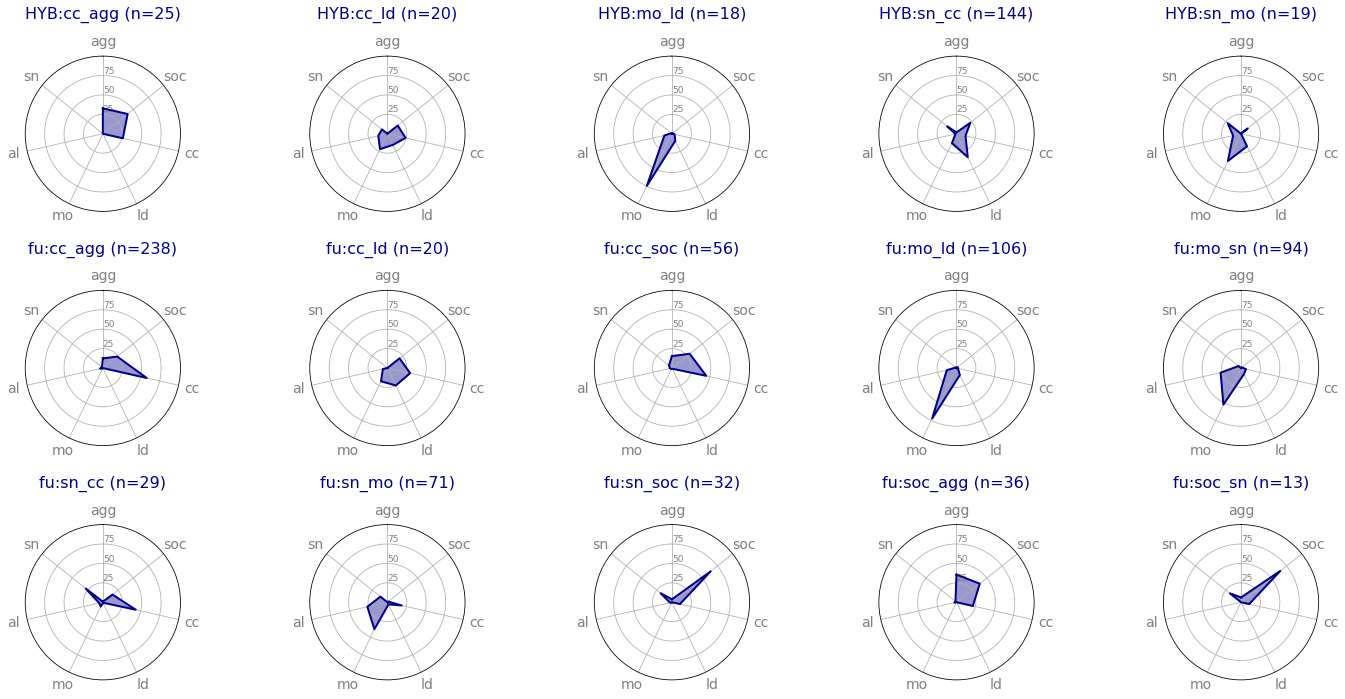

In [ ]:
def make_spider(row, title, color):
  # number of variable
  categories=list(grouped_filtered)[1:]
  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  ax = plt.subplot(3,5,row+1, polar=True, )
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories, color='grey', size=14)
  
  # Draw ylabels
  ax.set_rlabel_position(0)
  plt.yticks([25,50,75], ["25","50","75"], color="grey", size=9)
  plt.ylim(0,100)
  
  # Ind1
  values=grouped_filtered.loc[row].drop('label').values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
  ax.fill(angles, values, color=color, alpha=0.4)
  
  # Add a title
  plt.title(title, size=16, color=color, y=1.2)
 

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(20,10))

# Loop to plot
for row in range(0, len(grouped_filtered.index)):
  make_spider( row=row, title=grouped_filtered['label'][row]+" (n="+str(numbers_dict[grouped_filtered['label'][row]])+")", color="darkblue")

plt.tight_layout()
plt.savefig(FIGURES+'2020-10-21_hyb_fu_classi_k_5_neighbors_UMAP_ALL.png')

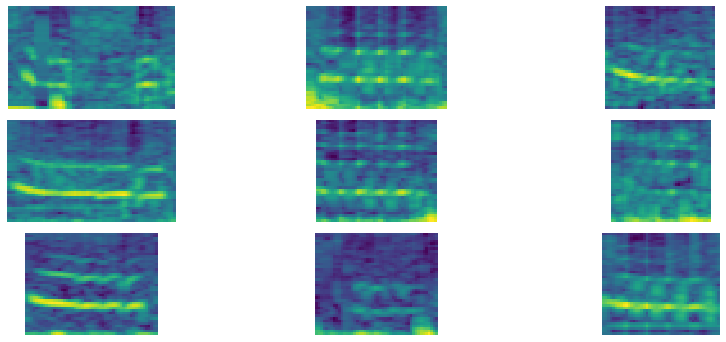

In [ ]:
# Look at fu_soc_sn calls
call_of_interest = 'HYB:cc_ld'
# Visualize examples
df_subset = df_hybfu.loc[ambi_labels==call_of_interest,:].sample(9, replace=False)

specs = df_subset.denoised_spectrograms.values

plt.figure(figsize=(12, 8))
plt.title(call_of_interest)
k=1
for i in range(len(specs)):
  #spec = pad_spectro(specs[i], 134)
  spec = specs[i]
  plt.subplot(5, 3, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal')
  plt.axis('off') 
  k=k+1
plt.tight_layout()
plt.savefig(FIGURES+call_of_interest+'_examples.png')

###Eval

In [ ]:
grouped_filtered

,label,agg,soc,cc,ld,mo,al,sn
0,HYB:cc_agg,27.200000,31.200000,19.200000,0.000000,2.400000,14.400000,5.600000
1,HYB:cc_ld,0.000000,5.000000,40.000000,2.000000,15.000000,27.000000,11.000000
2,HYB:mo_ld,0.000000,0.000000,5.555556,10.000000,61.111111,23.333333,0.000000
3,HYB:sn_cc,1.666667,7.083333,48.055556,1.388889,17.222222,10.138889,14.444444
4,HYB:sn_mo,1.052632,7.368421,18.947368,4.210526,20.000000,6.315789,42.105263
5,fu:cc_agg,18.655462,17.394958,37.142857,0.168067,1.428571,18.739496,6.470588
6,fu:cc_ld,1.000000,12.000000,64.000000,1.000000,8.000000,11.000000,3.000000
7,fu:cc_soc,17.857143,14.642857,44.642857,0.000000,2.142857,12.142857,8.571429
8,fu:mo_ld,0.188679,2.641509,19.245283,4.716981,45.660377,21.698113,5.849057
9,fu:mo_sn,0.212766,1.489362,16.595745,2.340426,32.978723,31.276596,15.106383


In [ ]:
hybfu_type = [i.split(':')[0] for i in grouped_filtered['label']]
two_labels = [i.split(':')[1] for i in grouped_filtered['label']]
first_lab = [i.split('_')[0] for i in two_labels]
second_lab = [i.split('_')[1] for i in two_labels]

In [ ]:
#selected_type = 'fu'
#selector = [True if x==selected_type else False for x in hybfu_type]
#grouped_filtered['label'][selector]

correct_dict={}
correct_dict['HYB'] = 0
correct_dict['fu'] = 0

for i in range(grouped_filtered.shape[0]):
  add_val = grouped_filtered.loc[i, first_lab[i]] + grouped_filtered.loc[i, second_lab[i]]
  correct_dict[hybfu_type[i]] = correct_dict[hybfu_type[i]] + add_val

In [ ]:
correct_dict['HYB']/np.sum(np.asarray([1 if x=='HYB' else 0 for x in hybfu_type]))

54.38385964912281

In [ ]:
correct_dict['fu']/np.sum(np.asarray([1 if x=='fu' else 0 for x in hybfu_type]))

69.99569162307083

How many of the calls had neighbors of both categories?

In [ ]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,index_id
0,HYB [LEAD + CC],HYB,ld,cc,cc,cc,cc,cc,cc,NaN
1,HYB [CC + LEAD],HYB,cc,ld,cc,cc,cc,cc,al,NaN
2,HYB [CC + LEAD],HYB,cc,ld,mo,cc,mo,cc,soc,NaN
3,HYB [CC + AGG],HYB,cc,agg,agg,soc,agg,soc,soc,NaN
4,HYB (SN+CC),HYB,sn,cc,mo,cc,sn,soc,agg,NaN
...,...,...,...,...,...,...,...,...,...,...
1027,HYB [CC+MOV],HYB,cc,mo,cc,cc,cc,cc,cc,NaN
1028,HYB [MOV+LD],HYB,mo,ld,mo,ld,al,mo,al,NaN
1029,HYB [MOV+LD],HYB,mo,ld,mo,al,al,al,mo,NaN
1030,HYB [CC+LD],HYB,cc,ld,soc,cc,cc,cc,cc,NaN


In [ ]:
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
in_neighbors = [0]* hybfu_classi.shape[0]

for i in range(hybfu_classi.shape[0]):
  neighbors = hybfu_classi_neighbors[i,:]
  if ((hybfu_classi.loc[i,'first_label'] in neighbors) and (hybfu_classi.loc[i,'second_label'] in neighbors)):
    in_neighbors[i] = 1

hybfu_classi['in_neighbors'] = in_neighbors

In [ ]:
for selected_type in ['HYB', 'fu']:
  hybfu_subset = hybfu_classi.loc[hybfu_classi['hybfu_type']==selected_type]
  print(selected_type, ":", np.sum(hybfu_subset['in_neighbors']), "of", hybfu_subset.shape[0], "(",np.sum(hybfu_subset['in_neighbors'])/hybfu_subset.shape[0], ")" )

HYB : 29 of 262 ( 0.11068702290076336 )
fu : 227 of 770 ( 0.2948051948051948 )


In [ ]:
1-0.8664122137404581

0.13358778625954193

In [ ]:
1-0.8311688311688312

0.16883116883116878

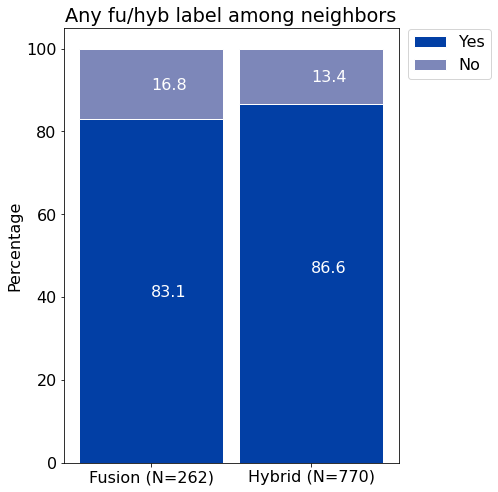

In [ ]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group
bars1 = [83.1168,86.6412]
bars2 = [16.88311, 13.358779]


# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N=262)',
         'Hybrid (N=770)']
barWidth = 0.9
 
# Create brown bars
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
# Create green bars (top)
lgd = plt.legend(bbox_to_anchor=(1.3, 0.94), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')

plt.text(0,40,'83.1', color="white")
plt.text(0,90,'16.8', color="white")

plt.text(1,46,'86.6', color="white")
plt.text(1,92,'13.4',color="white")

plt.title('Any fu/hyb label among neighbors')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(FIGURES+'hybfu_majorityvotes.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



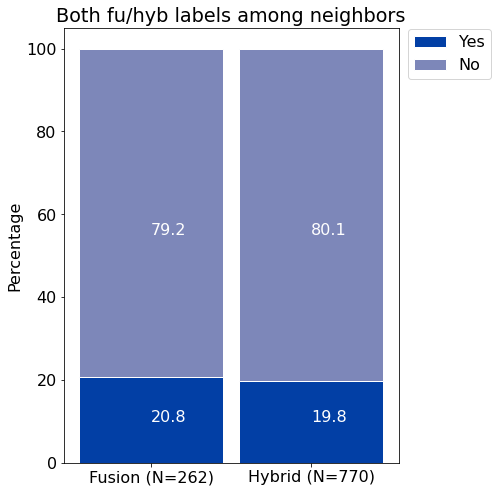

In [ ]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group
bars1 = [20.7792, 19.847328]
bars2 = [79.2208, 80.152672]

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N=262)',
         'Hybrid (N=770)']
barWidth = 0.9
 
# Create brown bars
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
# Create green bars (top)
lgd=plt.legend(bbox_to_anchor=(1.3, 0.94), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')

plt.text(0,10,'20.8', color="white")
plt.text(0,55,'79.2', color="white")

plt.text(1,10,'19.8', color="white")
plt.text(1,55,'80.1',color="white")

plt.title('Both fu/hyb labels among neighbors')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(FIGURES+'hybfu_both.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

How many of the calls had majority neighbors of at least one of the two labels?

In [ ]:
from collections import Counter

In [ ]:
majorityvote = []

for i in range(hybfu_classi.shape[0]):
  words_to_count = hybfu_classi_neighbors[i,:].tolist()
  c = Counter(words_to_count)
  x= c.most_common(5)
  
  x_counts = np.asarray([x[1] for x in x])
  x_labs = np.asarray([x[0] for x in x])
  max_val = np.max(x_counts)
  selector = np.where(x_counts==max_val)[0]
  majorityvote.append(x_labs[selector])

In [ ]:
in_majority = []

for i in range(hybfu_classi.shape[0]):
  if (len(majorityvote[i])>1):
    in_majority.append('tie')
  else:
    in_majority.append(majorityvote[i][0])

In [ ]:
# when ties count
in_majority = []

for i in range(hybfu_classi.shape[0]):
  if (len(majorityvote[i])==2):
    # any of these in label?
    if (hybfu_classi.loc[i,'first_label'] in majorityvote[i]):
      in_majority.append(hybfu_classi.loc[i,'first_label'])
    elif (hybfu_classi.loc[i,'second_label'] in majorityvote[i]):
      in_majority.append(hybfu_classi.loc[i,'second_label'])
    else:
      in_majority.append('tie')
  elif len(majorityvote[i])>2:
    in_majority.append('tie')
  else:
    in_majority.append(majorityvote[i][0])

In [ ]:
lens = [len(x) for x in majorityvote]

In [ ]:
pd.Series(lens).value_counts()

1    896
2    136
dtype: int64

In [ ]:
hybfu_classi['in_majority'] = in_majority

In [ ]:
majority_in_label = []

for i in range(hybfu_classi.shape[0]):
  majority = hybfu_classi.loc[i,'in_majority']
  if majority=='tie':
    majority_in_label.append('tie')
  elif ((majority==hybfu_classi.loc[i,'first_label']) or (majority==hybfu_classi.loc[i,'second_label'])):
    majority_in_label.append('yes')
  else:
    majority_in_label.append('no')

hybfu_classi['majority_in_label'] = majority_in_label
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,index_id,in_neighbors,in_majority,majority_in_label
0,HYB [LEAD + CC],HYB,ld,cc,ld,sn,mo,soc,ld,NaN,0,ld,yes
1,HYB [CC + LEAD],HYB,cc,ld,soc,soc,soc,ld,ld,NaN,0,soc,no
2,HYB [CC + LEAD],HYB,cc,ld,soc,soc,ld,ld,soc,NaN,0,soc,no
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,soc,agg,NaN,0,agg,yes
4,HYB (SN+CC),HYB,sn,cc,ld,ld,ld,soc,ld,NaN,0,ld,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,HYB [CC+MOV],HYB,cc,mo,soc,soc,soc,soc,cc,NaN,0,soc,no
1028,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,sn,NaN,0,mo,yes
1029,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,NaN,0,mo,yes
1030,HYB [CC+LD],HYB,cc,ld,cc,cc,cc,cc,cc,NaN,0,cc,yes


In [ ]:
#above10_labels = pd.DataFrame(pd.Series(hybfu_calls).value_counts()[pd.Series(hybfu_calls).value_counts()>10]).index.tolist()
#selector = [True if x in above10_labels else False for x in hybfu_calls]
#hybfu_classi = hybfu_classi.loc[selector,:]

In [ ]:
eval_tab = np.zeros((3,2))
for i,selected_type in enumerate(['fu', 'HYB']):
  #hybfu_subset = hybfu_classi.loc[selector,:] # when selecting only n>10
  #hybfu_subset = hybfu_subset.loc[hybfu_classi['hybfu_type']==selected_type] # when selecting only n>10
  hybfu_subset = hybfu_classi[hybfu_classi['hybfu_type']==selected_type]
  print(selected_type)
  print(hybfu_subset['majority_in_label'].value_counts())
  eval_tab[:,i] = np.asarray(hybfu_subset['majority_in_label'].value_counts())
eval_tab = pd.DataFrame(eval_tab)
eval_tab.columns = ['fu', 'HYB']
eval_tab.index = ['yes', 'no', 'tie']
eval_tab

fu
yes    512
no     158
tie    100
Name: majority_in_label, dtype: int64
HYB
no     135
yes     91
tie     36
Name: majority_in_label, dtype: int64


,fu,HYB
yes,512.0,135.0
no,158.0,91.0
tie,100.0,36.0


In [ ]:
eval_percent = eval_tab.copy()
eval_percent['fu'] = (eval_tab['fu'] / eval_tab['fu'].sum()) * 100
eval_percent['HYB'] = (eval_tab['HYB'] / eval_tab['HYB'].sum()) * 100
eval_percent

,fu,HYB
yes,66.493506,51.526718
no,20.519481,34.732824
tie,12.987013,13.740458


In [ ]:
'Fusion (N='+str(int(np.sum(eval_tab.loc[:,'fu'])))+")"

'Fusion (N=695)'

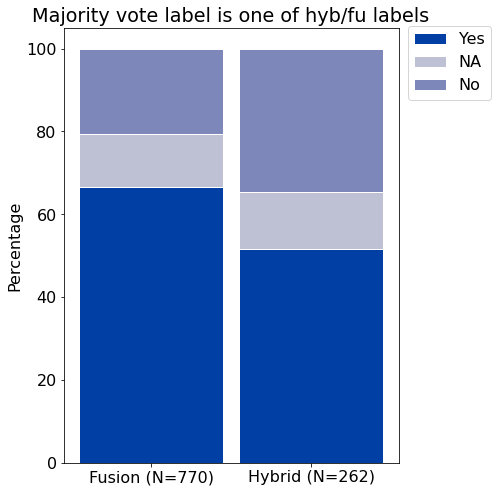

In [ ]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group

bars1 = eval_percent.loc['yes',:]
bars2 = eval_percent.loc['tie',:]
bars3 = eval_percent.loc['no',:]

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N='+str(int(np.sum(eval_tab.loc[:,'fu'])))+")",
         'Hybrid (N='+str(int(np.sum(eval_tab.loc[:,'HYB'])))+")"]
barWidth = 0.9
 
# Create brown bars
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color="#bec1d4", edgecolor='white', width=barWidth, label="NA")
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
lgd=plt.legend(bbox_to_anchor=(1.3, 0.92), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')


#plt.text(0,56,round(eval_percent.loc['tie','fu'],1), color="white")
#plt.text(0,25,round(eval_percent.loc['yes','fu'],1), color="white")
#plt.text(0,81,round(eval_percent.loc['no','fu'],1), color="white")

#plt.text(1,63,round(eval_percent.loc['tie','HYB'],1), color="white")
#plt.text(1,30,round(eval_percent.loc['yes','HYB'],1), color="white")
#plt.text(1,85,round(eval_percent.loc['no','HYB'],1), color="white")

plt.title('Majority vote label is one of hyb/fu labels')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(FIGURES+'hybfu_majority_vote_ALL.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [ ]:
hybfu_classi.loc[hybfu_classi['in_majority']=='tie',:]

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,index_id,in_neighbors,in_majority,majority_in_label
4,HYB (SN+CC),HYB,sn,cc,mo,cc,sn,soc,agg,NaN,1,tie,tie
24,HYB (SN+CC),HYB,sn,cc,mo,mo,al,soc,al,NaN,0,tie,tie
41,HYB (SN+CC),HYB,sn,cc,ld,cc,mo,mo,ld,NaN,0,tie,tie
76,HYB (SN+CC),HYB,sn,cc,mo,mo,soc,cc,soc,NaN,0,tie,tie
110,HYB [CC+AGG],HYB,cc,agg,agg,mo,soc,al,cc,NaN,1,tie,tie
120,HYB [SN+CC]?,HYB,sn,cc,mo,soc,soc,mo,sn,NaN,0,tie,tie
132,HYB [CC+LEAD],HYB,cc,ld,cc,sn,al,sn,al,NaN,0,tie,tie
195,fu s+ld *,fu,sn,ld,cc,mo,soc,soc,cc,NaN,0,tie,tie
219,HYB (SN+LD),HYB,sn,ld,ld,al,mo,al,mo,NaN,0,tie,tie
222,HYB (SN+MOVE),HYB,sn,mo,ld,cc,ld,al,cc,NaN,0,tie,tie


In [ ]:
plt.style.use('seaborn-colorblind10')

ax = eval_percent.T.plot.bar(stacked=True, figsize=(10, 6))
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Percentage of calls')


# Loop to add on each bar a tag in position
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom')

OSError: ignored

Joyplot

In [ ]:
os.system('pip install joy')

0

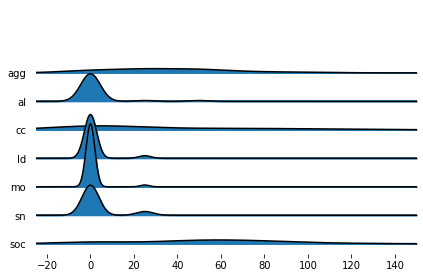

In [ ]:
label_of_interest = 'fu:soc_agg'
sub_df = hybfu_neighbor_tab.loc[hybfu_neighbor_tab['label']==label_of_interest].drop(columns='label')
fig, ax = joypy.joyplot(sub_df)#, hist="True")

# Old stuff

In [ ]:
k=10

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embed)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
labels = df.call_lable
labelnames = df.Name

In [ ]:
fu_hyb_indices = np.asarray(np.where(labels=='fu/hyb'))[0]

In [ ]:
fu_hyb_indices = np.asarray(np.where(labels=='fu/hyb'))[0]

for i,ind in enumerate(fu_hyb_indices):
  nearest_neighbors = indices[ind]
  neighbor_labels = [labels[neighbor] for neighbor in nearest_neighbors]
  print(labelnames[ind], " : ", neighbor_labels)

HYB [LEAD + CC]  :  ['fu/hyb', 'soc', 'fu/hyb', 'ld', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb']
HYB [CC + LEAD]  :  ['soc', 'fu/hyb', 'fu/hyb', 'ld', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'cc']
HYB [CC + LEAD]  :  ['fu/hyb', 'soc', 'cc', 'cc', 'fu/hyb', 'fu/hyb', 'soc', 'fu/hyb', 'fu/hyb', 'ld']
HYB [CC + AGG]  :  ['agg', 'agg', 'agg', 'agg', 'soc', 'soc', 'agg', 'fu/hyb', 'soc', 'fu/hyb']
HYB (SN+CC)  :  ['fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb']
HYB (SN+CC)  :  ['sn', 'fu/hyb', 'sn', 'fu/hyb', 'sn', 'ld', 'soc', 'soc', 'soc', 'ld']
HYB (SN+CC)  :  ['mo', 'sn', 'fu/hyb', 'sn', 'sn', 'sn', 'sn', 'mo', 'mo', 'sn']
HYB (SN+CC)  :  ['fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb']
HYB (SN+CC)  :  ['agg', 'soc', 'agg', 'agg', 'agg', 'agg', 'agg', 'agg', 'soc', 'soc']
HYB (SN+CC)  :  ['fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 

In [ ]:
fu_hyb_indices = np.asarray(np.where(df.call_lable=='fu/hyb'))[0]

nn_stats_dict = {}
calltypes = sorted(list(set(labels)))
labels = np.asarray(labels)

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
  nn_stats_dict[calltype] = calltype_counts